# Übung 8: Clustering

Student: Remo Schwarzentruber

##  Aufgabe 1: K-Means

Clustering ist eine Methode um mittles Unsupervised Learning zusammen gehörende Daten zu finden und kann für verschiedene Daten angewendet werden.

In dieser Übung möchten wir versuchen, damit ähnlichfarbige Objekte/Regionen in Bildern zu erkennen.

In [2]:
# OpenCV needs to be included first
import cv2
import numpy as np

# for displaying images in jupyter
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 500

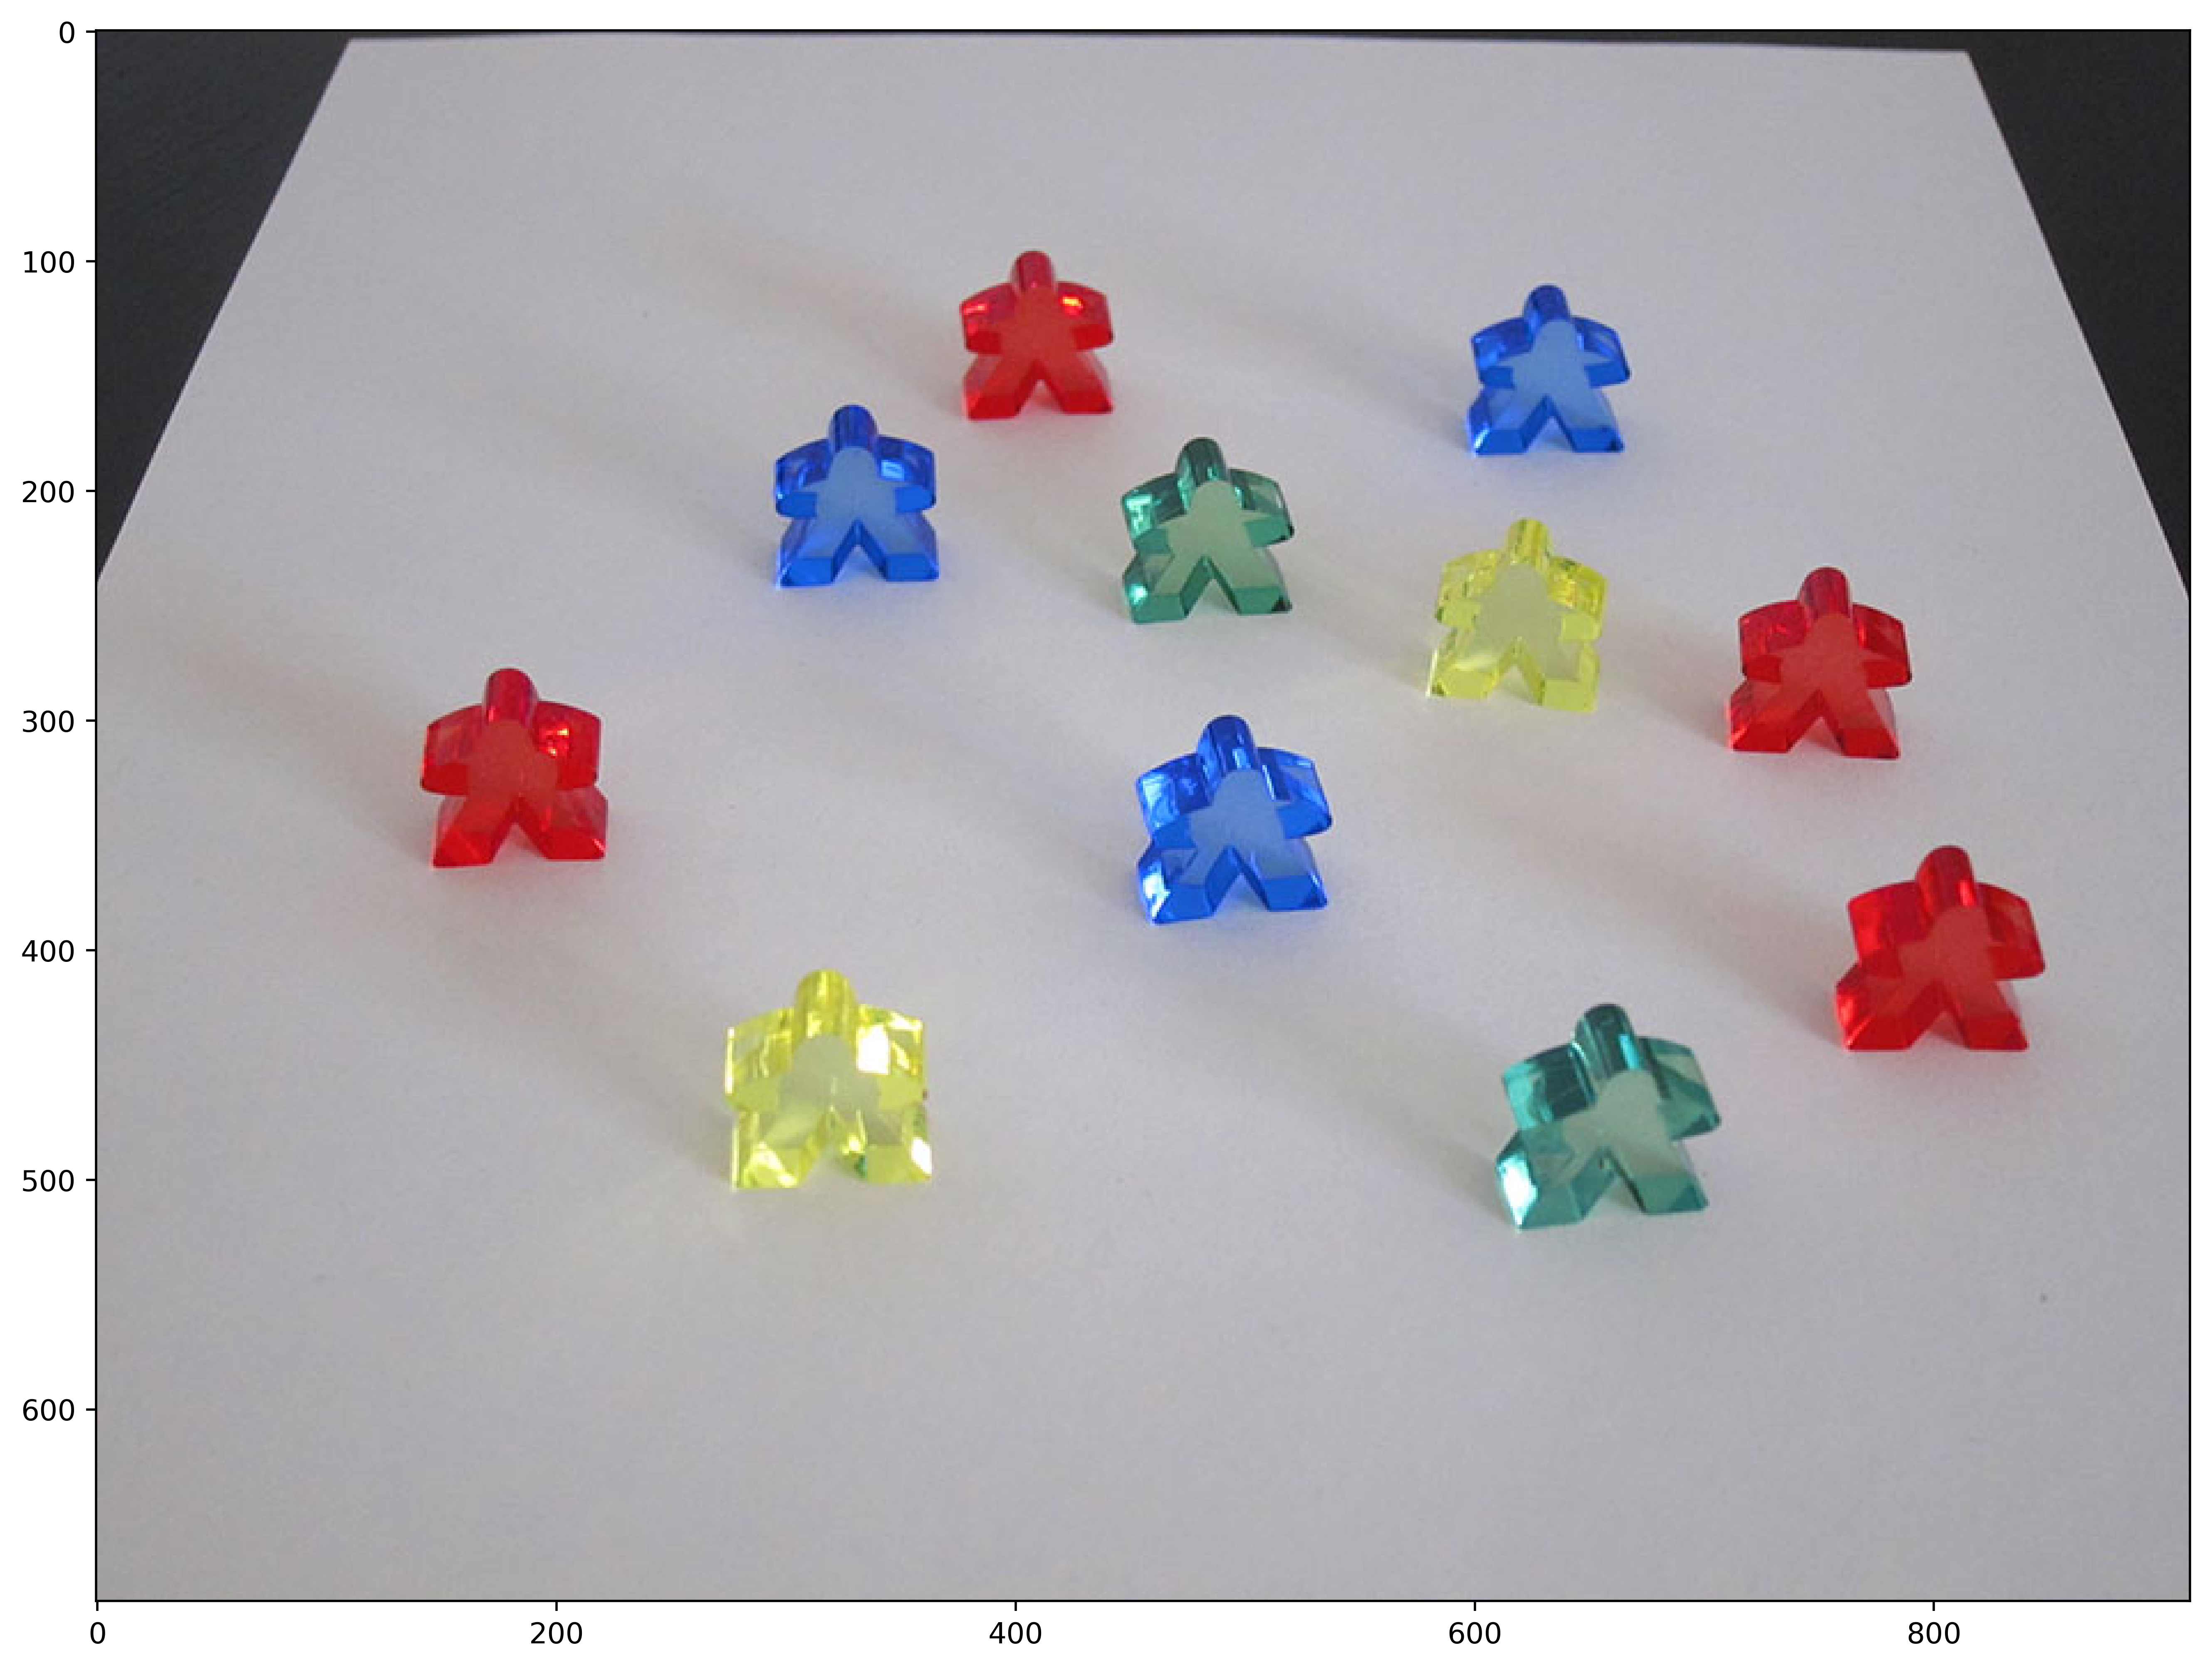

In [3]:
image  = cv2.imread('../data/figures.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(image)

### Clustering

Auf dem obigen Bild sollen die verschiedenen Figuren anhand ihrer Farbe detektiert werden. Dazu soll Clustering verwendet werden. OpenCV enthält dafür eine Implementation von k-Means. Als Input wird dabei ein (1D-) Array von Farbwerten verwendet, sie müssen das Bild also von einem 2D Array von RGB in ein 1D Array von RGB umwandeln. Dazu kann `reshape` (numpy) verwendet werden.


In [4]:
data = image.reshape((-1,3))
data_float = np.float32(data)
print(data_float.shape)

(623808, 3)


Wenden Sie nun die Funktion `cv2.kmeans(...)` an. Als TermCriteria können sie die folgende Struktur benutzen. Wenn Sie keine Centren initialisieren wollen, können sie als Labels `None` übergeben.

In [5]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Set flags (Select random initial centers in each attempt.)
flags = cv2.KMEANS_RANDOM_CENTERS

# KMeans
compactness, labels, centers = cv2.kmeans(data_float, 7, None, criteria, 10, flags)

# Now convert back into uint8, and make original image
centers = np.uint8(centers)
res = centers[labels.flatten()]
res2 = res.reshape((image.shape))

Stellen Sie das Resultat wieder als Bild dar. Dazu können Sie zum Beispiel die Cluster Centers verwenden und das Label Bild wieder auf das 2 dimensionale Bildraster umformen.

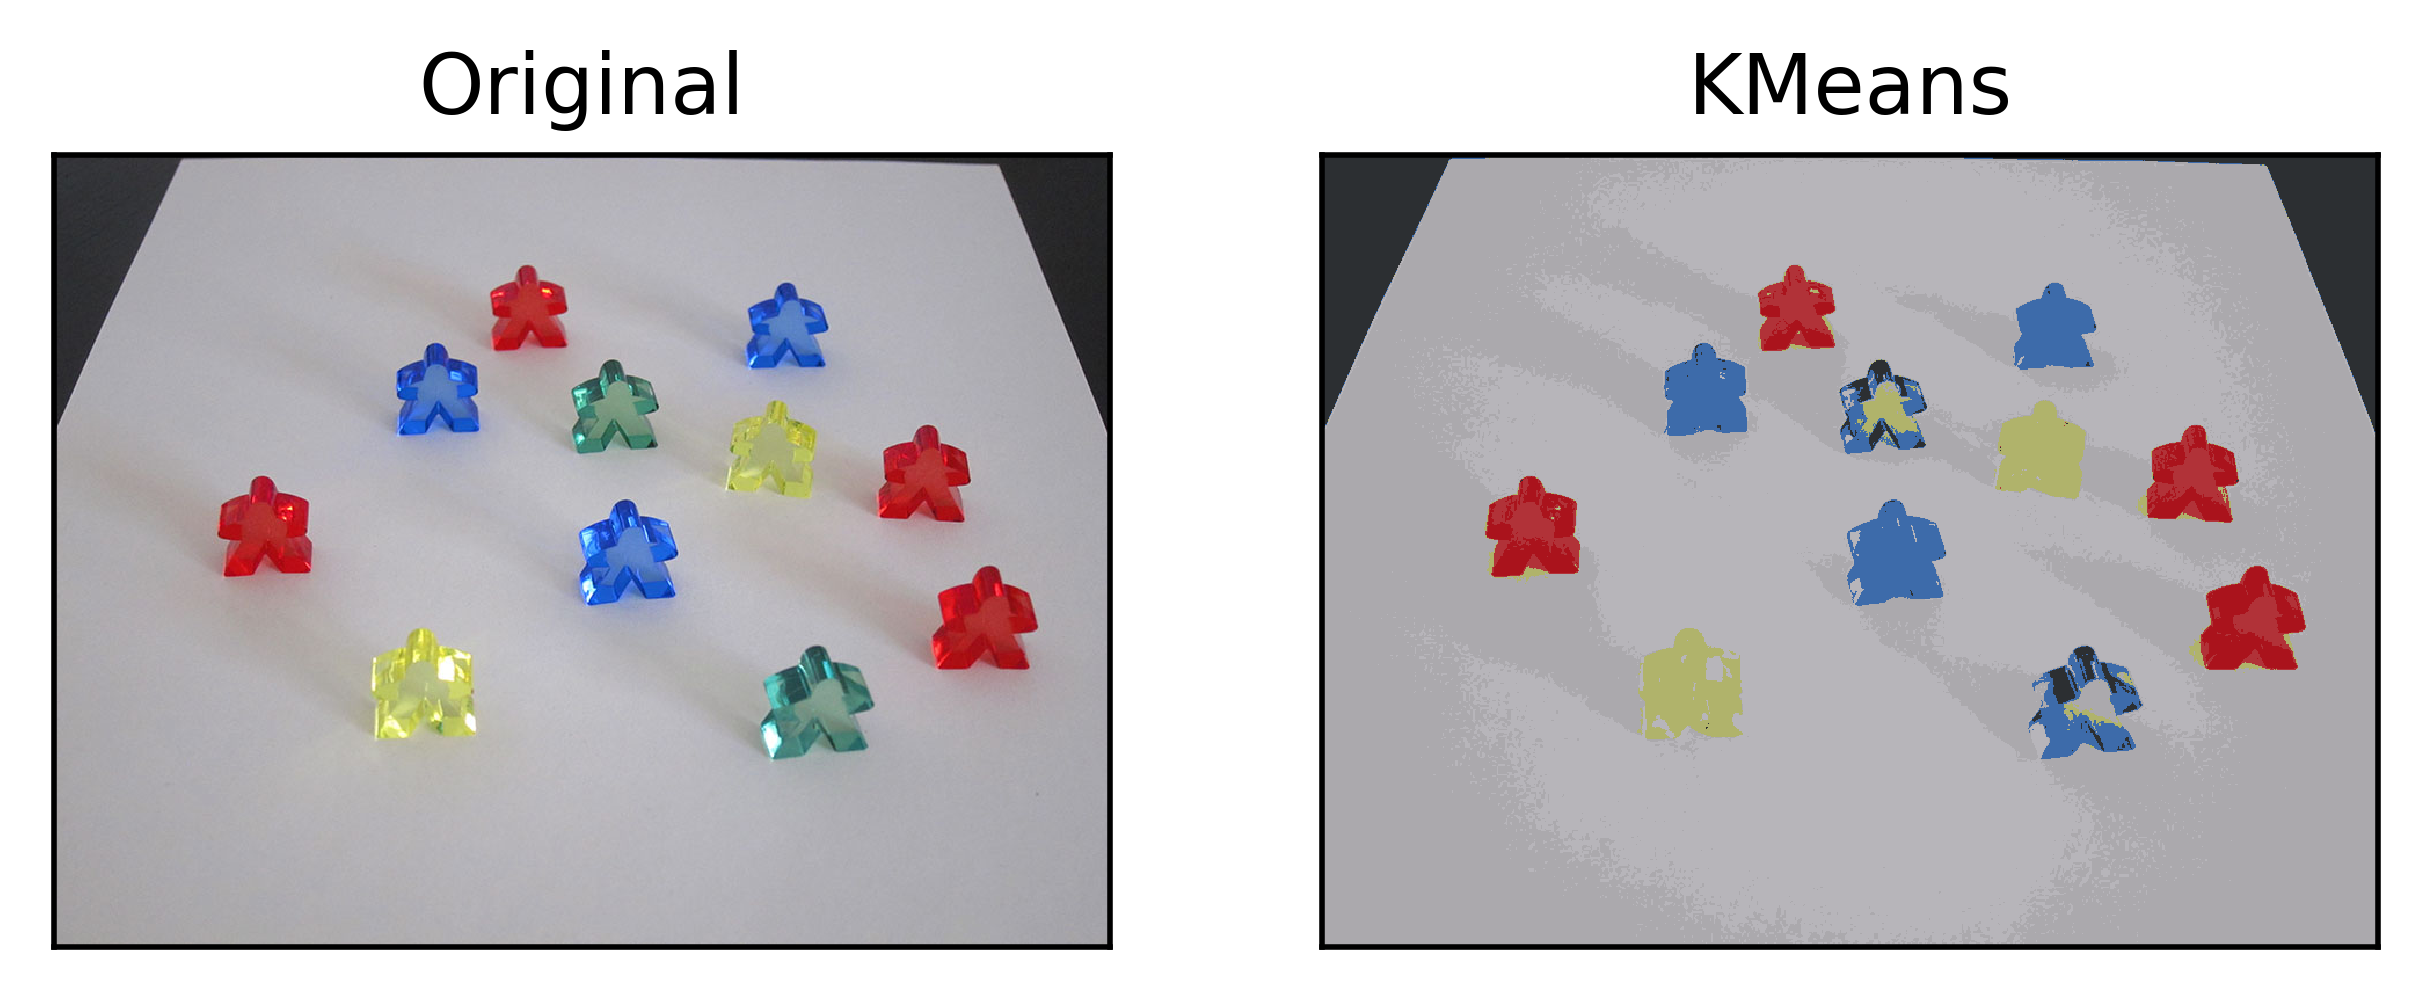

In [6]:
plt.subplot(1, 2, 1)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title('KMeans'), plt.xticks([]), plt.yticks([])
plt.imshow(res2)

plt.show()

Alternativ können Sie zur Überlagerung von Bildern und Label auch die Funktion ```skimage.color.label2rgb``` verwenden.

Probieren Sie verschiedene Werte von K. Wie erreichen Sie die besten Resultate. Wie überprüfen Sie die Qualität der Resultate?

`Lösung: Das Beste Resultat wird mit sieben (7) Cluster erreichet.`

### Aufgabe 2: Mean Shift

OpenCV enthält auch eine Funktion um Mean Shift durchzuführen: `pyrMeanShiftFiltering`. Allerdings kann diese nur direkt auf Bildern angewendet werden und nicht auf allgemeine Daten. 

Wenden Sie die Funktion auf das ursprüngliche Bild an und interpretieren Sie das Resultat.

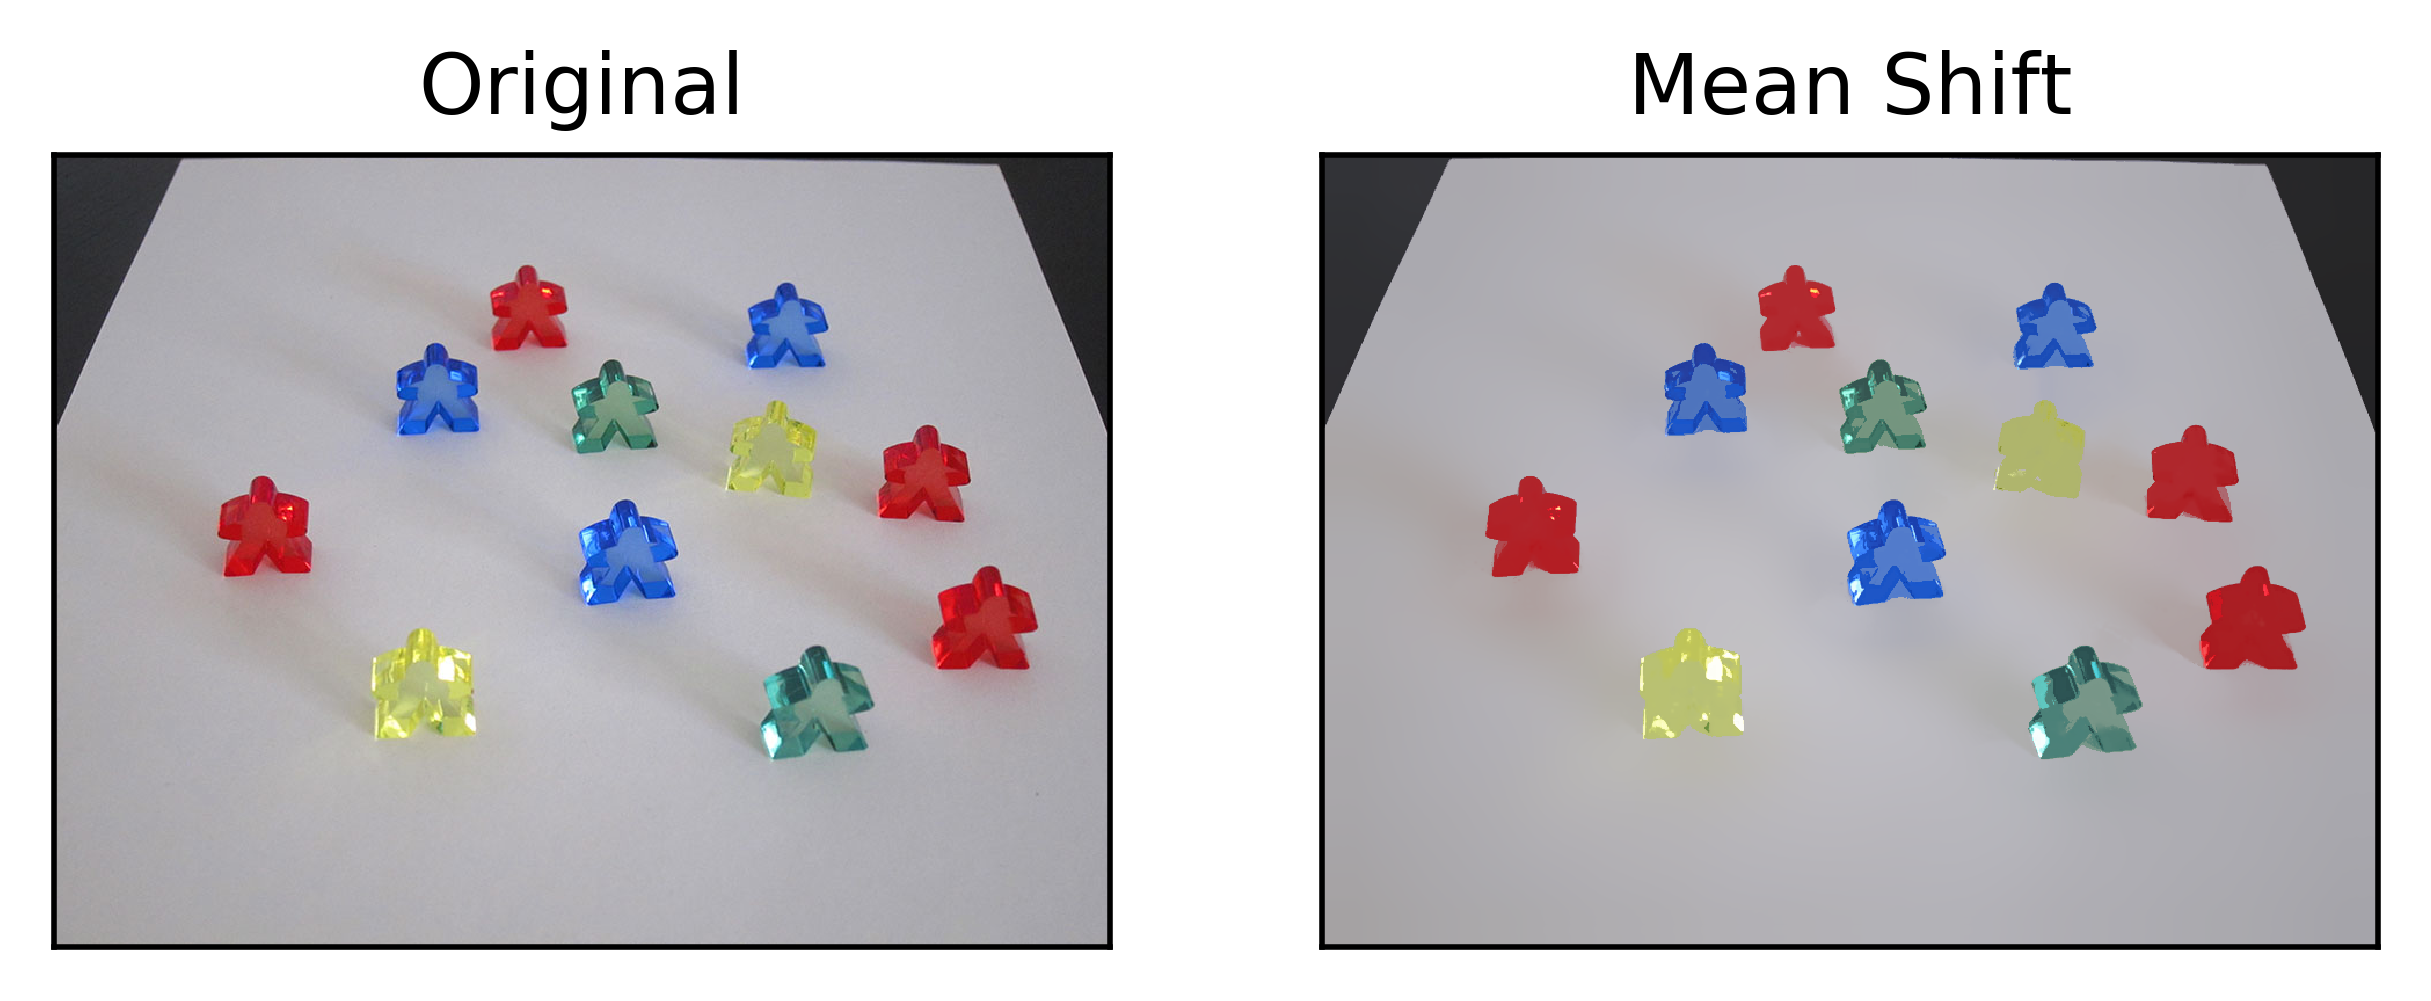

In [7]:
image  = cv2.imread('../data/figures.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

res3 = cv2.pyrMeanShiftFiltering(image, 30.0, 30.0, res2)

plt.subplot(1, 2, 1)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title('Mean Shift'), plt.xticks([]), plt.yticks([])
plt.imshow(res3)

plt.show()

## Aufgabe 3: Superpixel und GraphCut

Die Skimage Bibliothek enthält Graph Cut Algorithmen um ein Bild zu segmentieren. Dazu sollte es allerdings besser zuerst in Superpixels unterteilt werden, und diese dann mittels Graphcut weiter segmentiert werden.

Eine Implementation des Superpixels Clustering ist *slic*, das sowohl im Pixel- wie auch im Farbraum clustered:

http://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic

Segmentieren Sie das Bild in Superpixel, die Anzahl Regionen kann dabei als Parameter angegeben werden.


Source Code: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html#sphx-glr-auto-examples-segmentation-plot-segmentations-py

Felzenszwalb number of segments: 140
SLIC number of segments: 226
Quickshift number of segments: 665


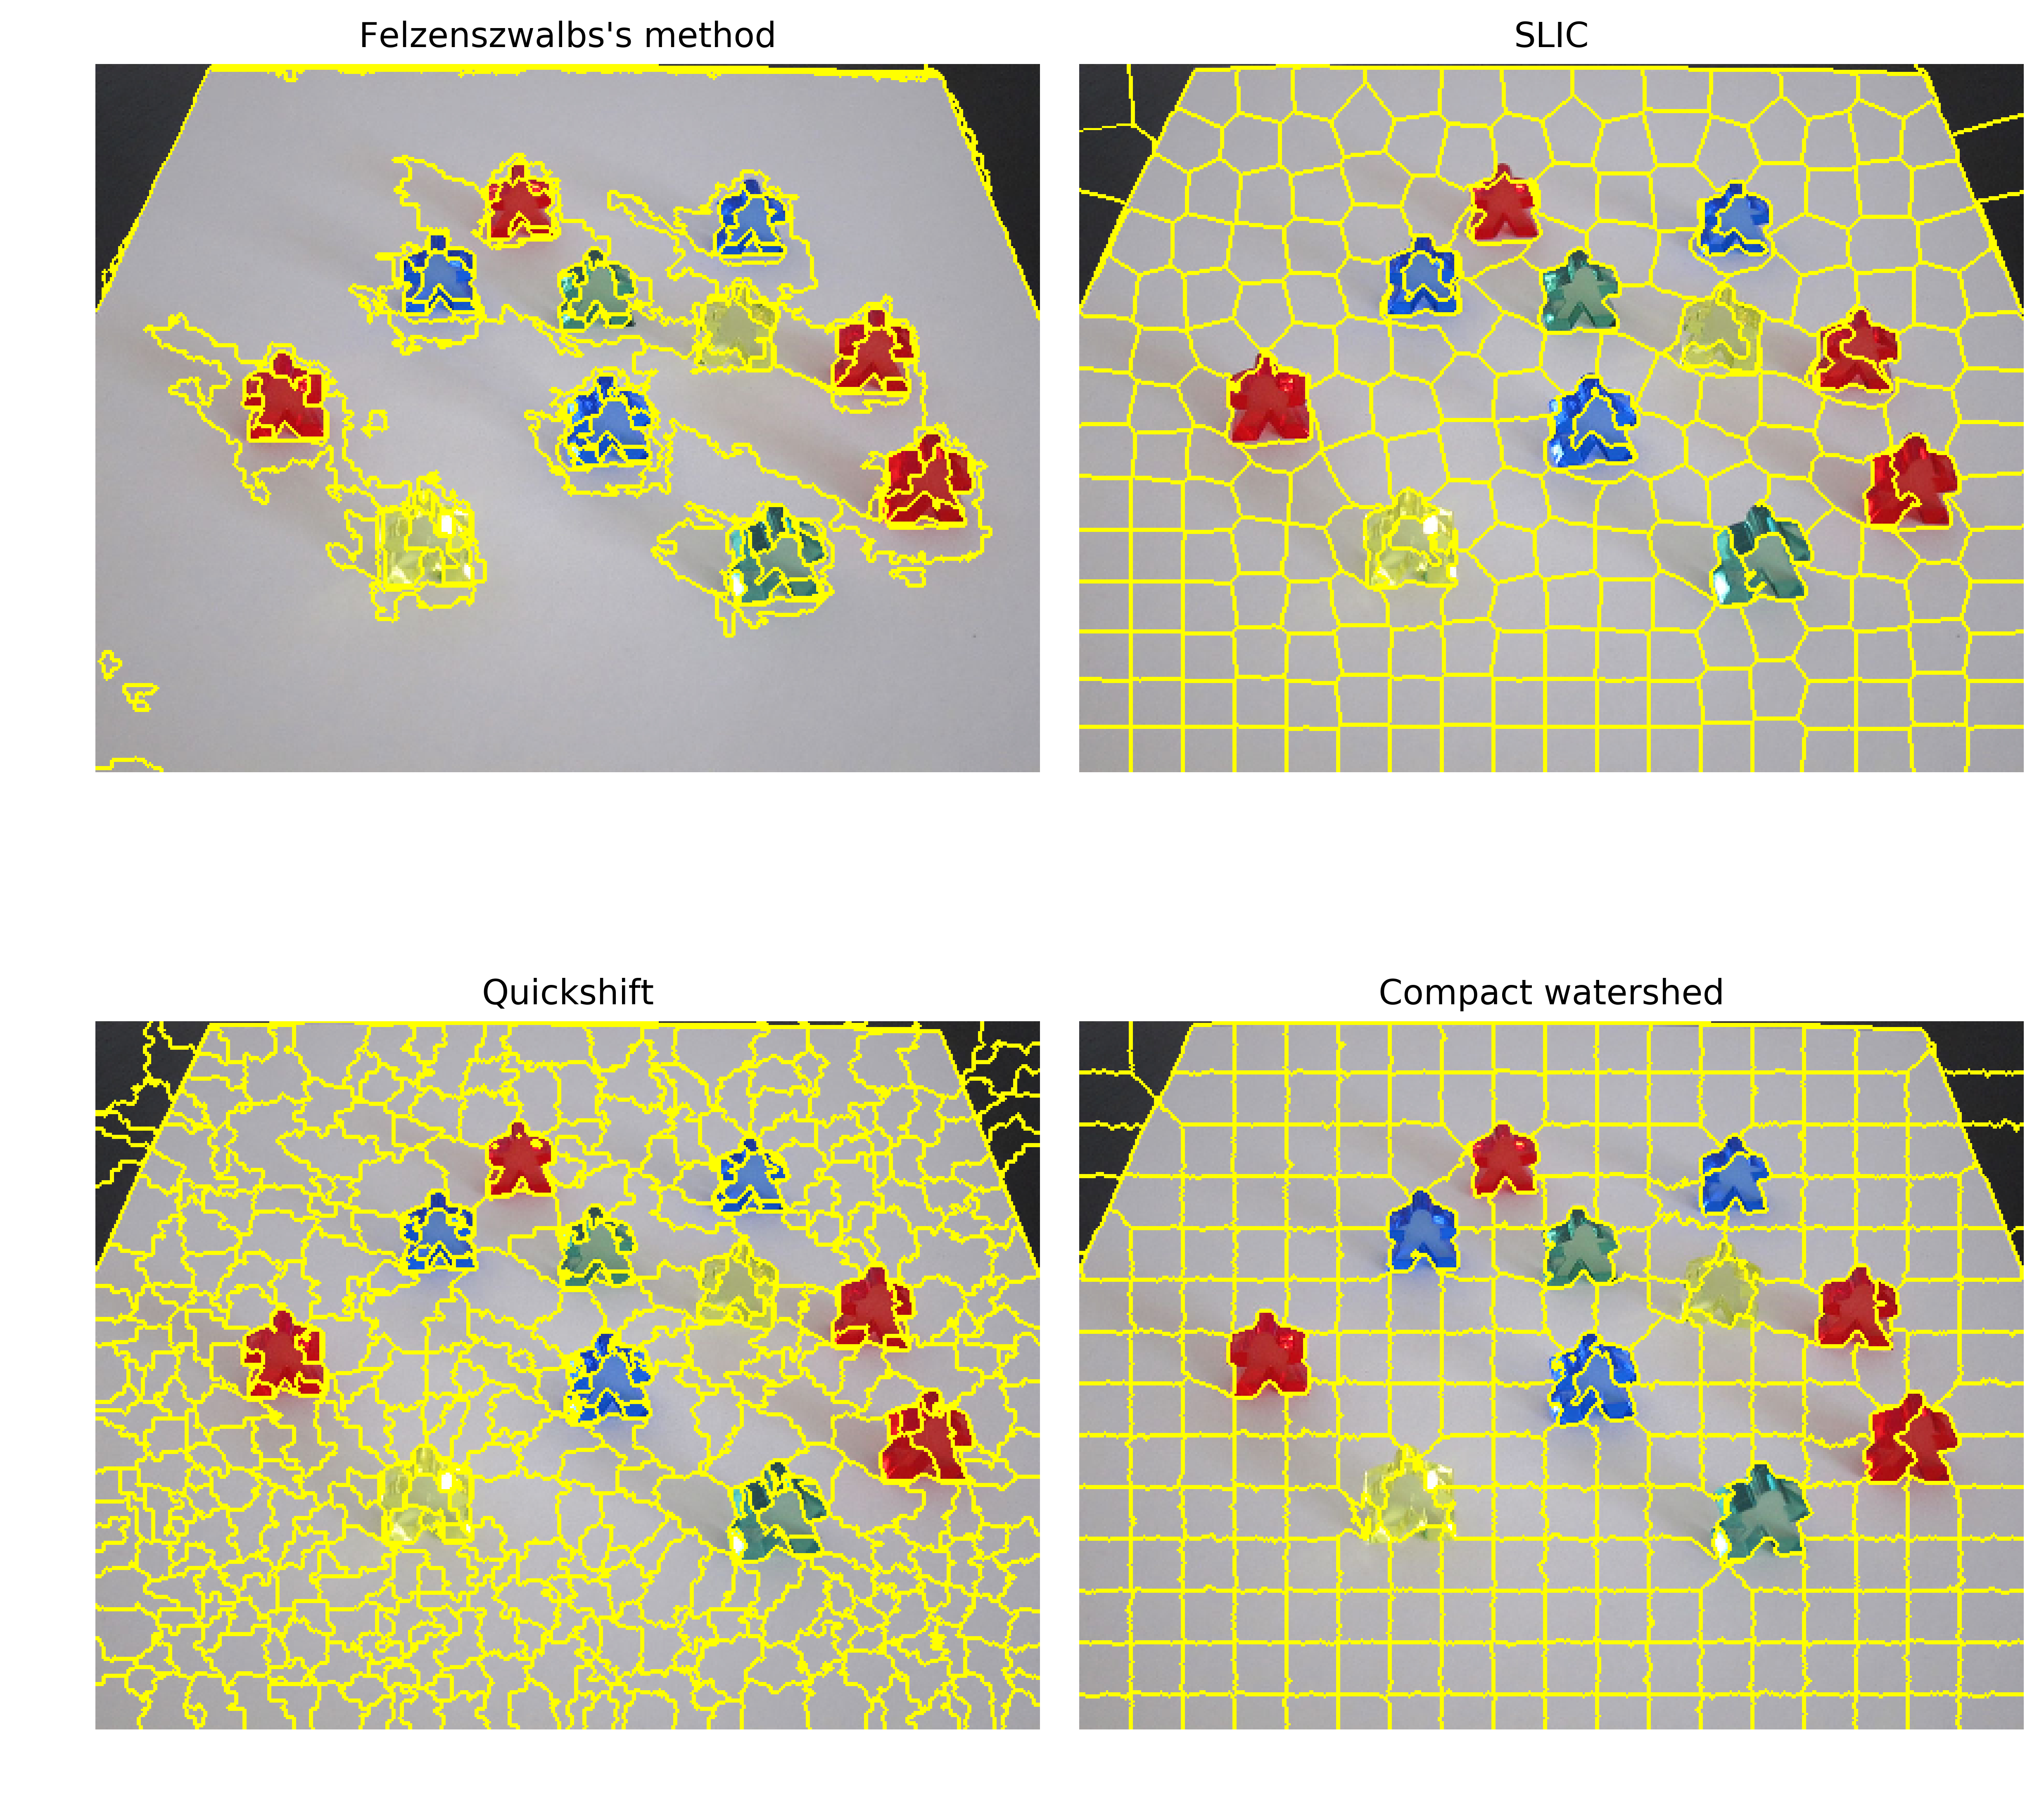

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

image  = cv2.imread('../data/figures.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = img_as_float(image[::2, ::2])

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print("Felzenszwalb number of segments: {}".format(len(np.unique(segments_fz))))
print('SLIC number of segments: {}'.format(len(np.unique(segments_slic))))
print('Quickshift number of segments: {}'.format(len(np.unique(segments_quick))))

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

Für die weitere Verarbeitung, muss zuerst der *Region Adjacency Graph* berechnet werden:

http://scikit-image.org/docs/dev/api/skimage.future.graph.html#skimage.future.graph.rag_mean_color

auf diesem kann dann der Graphcut Algorithmus durchgeführt werden.

http://scikit-image.org/docs/dev/api/skimage.future.graph.html#skimage.future.graph.cut_normalized

Verwenden Sie beides und stellen Sie das Resultat dar.

Source Code: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_ncut.html#sphx-glr-auto-examples-segmentation-plot-ncut-py

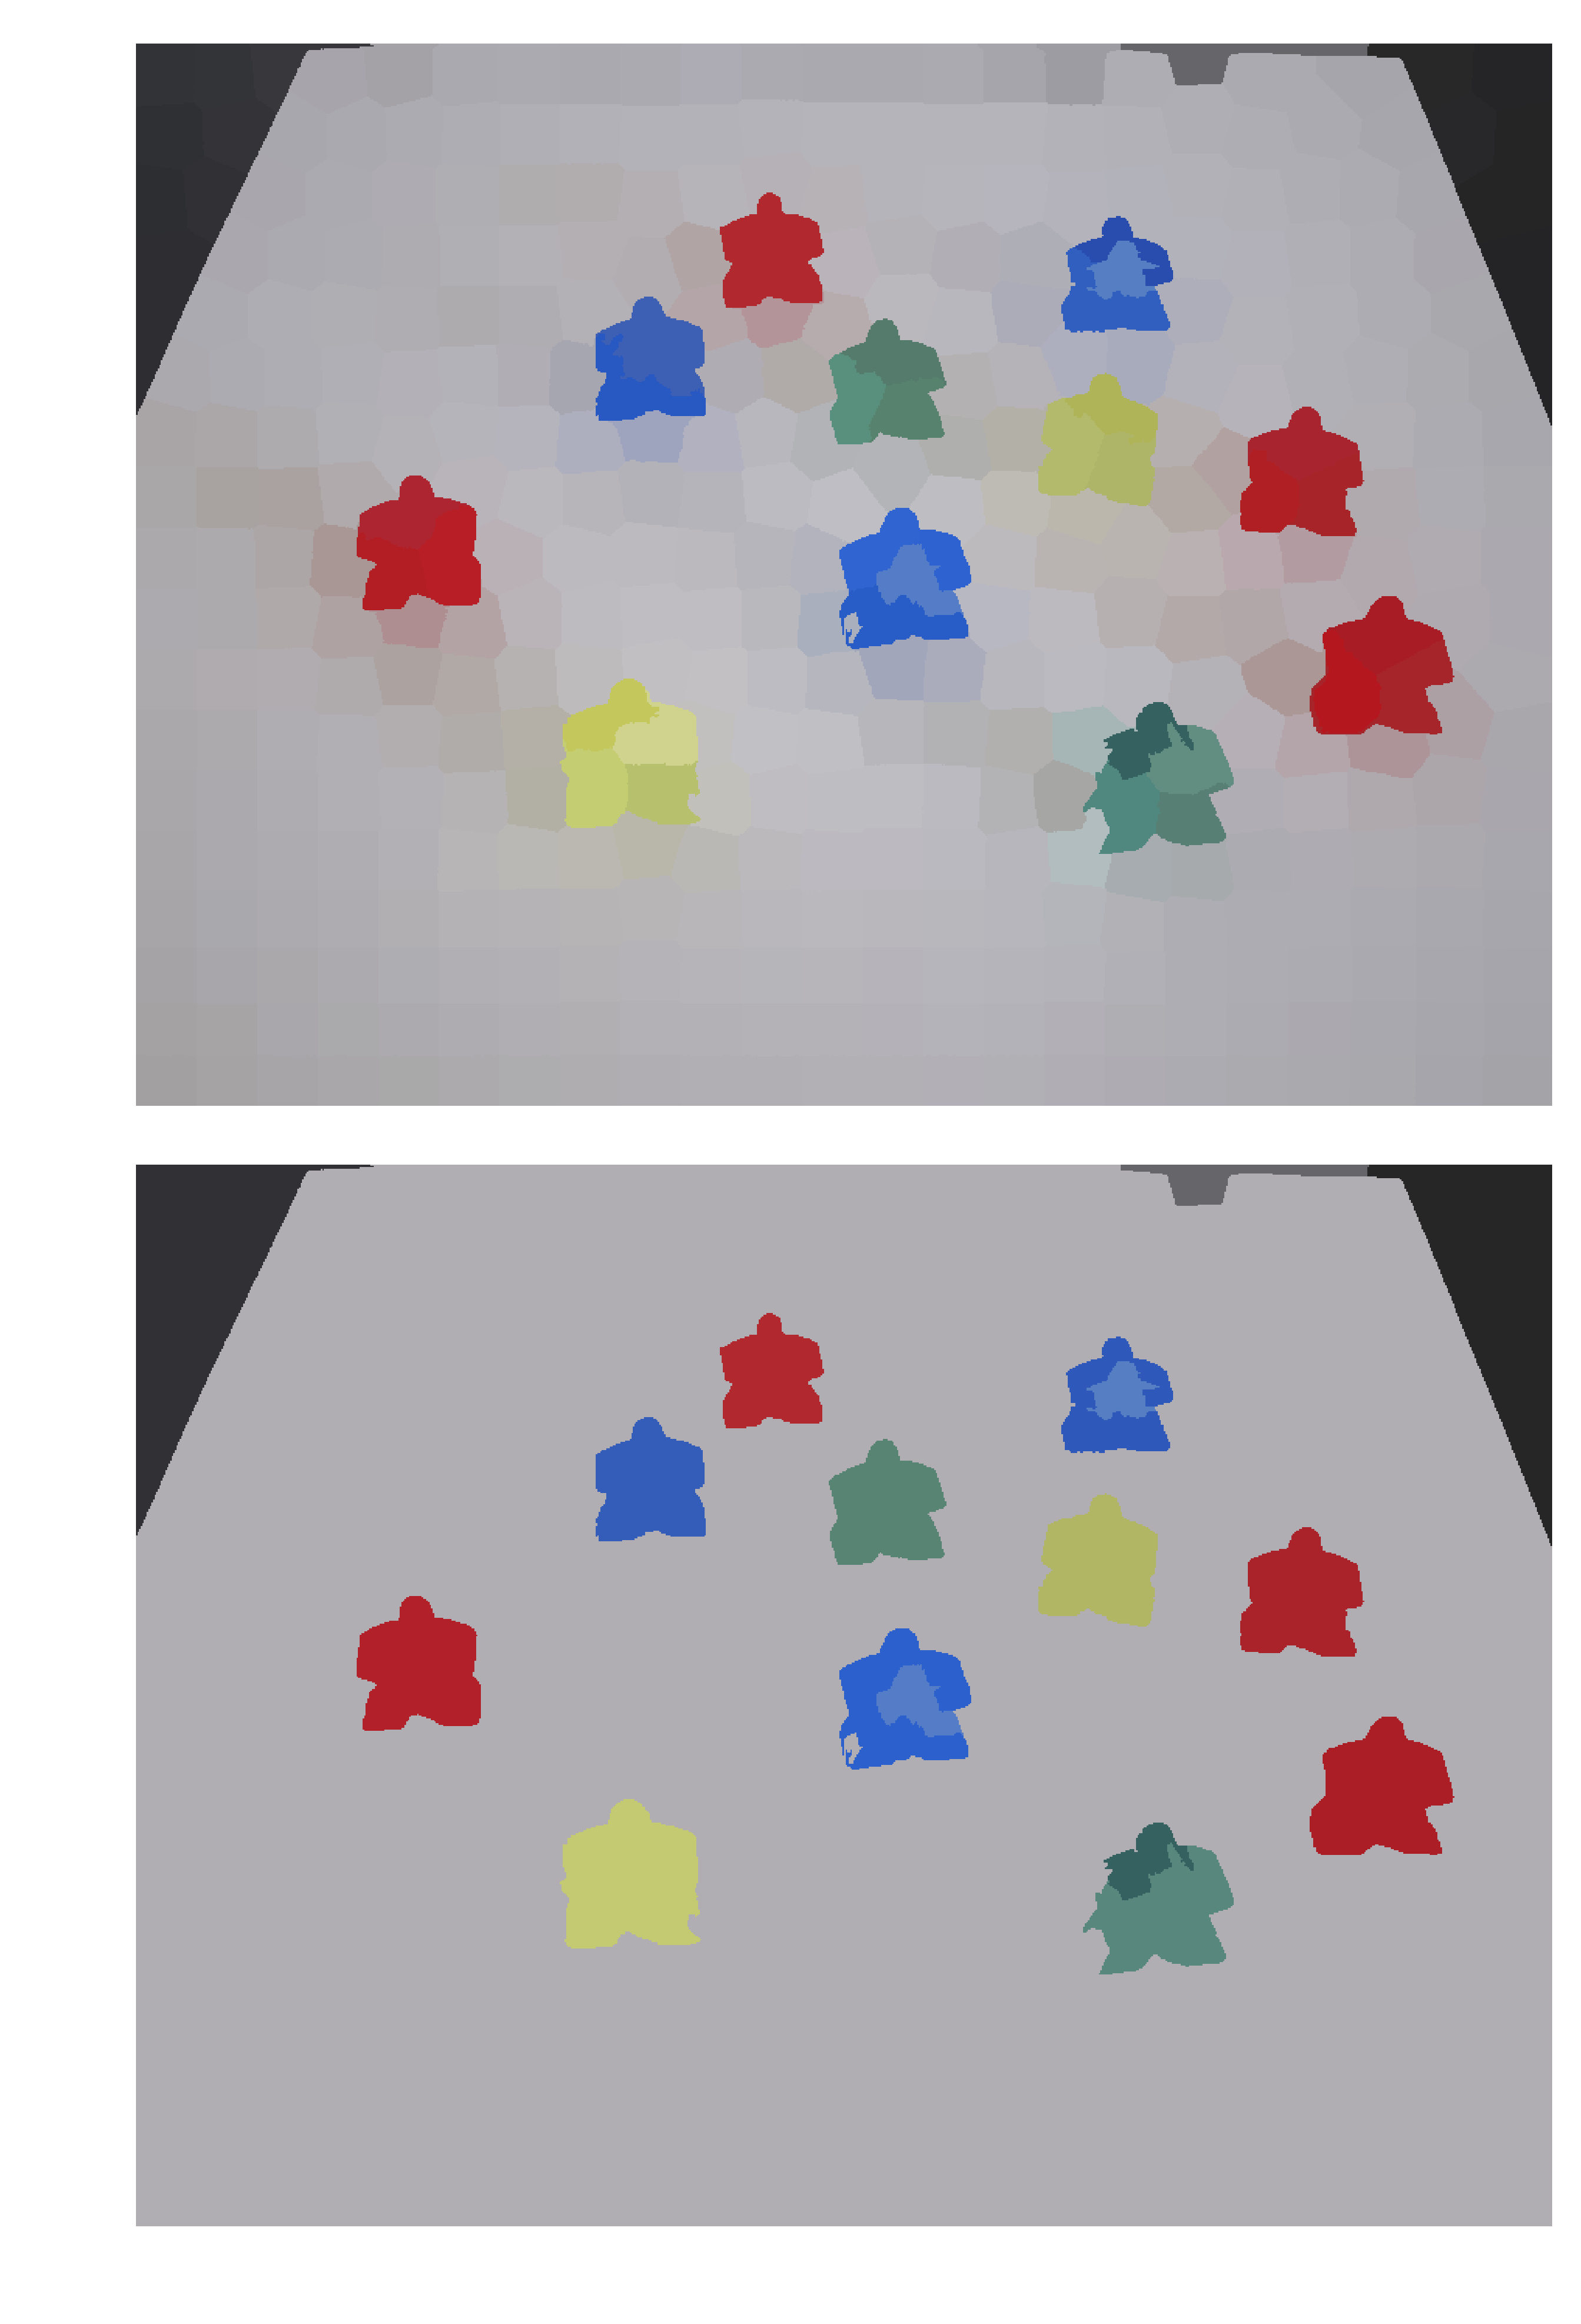

In [9]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt


image  = cv2.imread('../data/figures.jpg')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

labels1 = segmentation.slic(img, compactness=30, n_segments=400)
out1 = color.label2rgb(labels1, img, kind='avg')

g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg')

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()